# single cell RNA-seq analysis

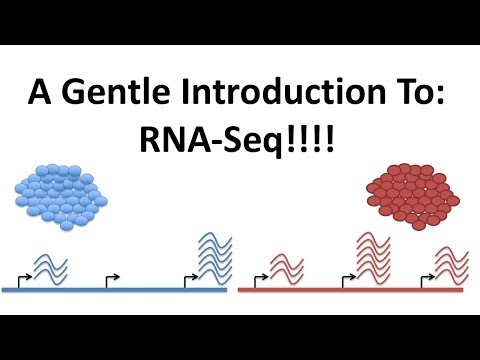

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('tlf6wYJrwKY')

The central dogma of molecular biology describes the two-step process, transcription and translation, by which the information in genes flows into proteins: DNA → RNA → protein. Transcription is the synthesis of an RNA copy of a segment of DNA. RNA is synthesized by the enzyme RNA polymerase.

Besides mRNA, tRNA and rRNA which are important for protein synthesis, there are many other types of RNA that play a huge roll in the regulatory programms of cells.

single-cell RNA-sequencing is a technique where the expression of RNA in single cells can be measured.

Measuring and analyzing such data can give insights in for example celltype specific regulation and can help to understand the progress of deseases.

Imputation is the process of replacing missing data with substitute values.

In scRNAseq protocols that measure the expression, dropout events can happen. Although RNA molecules are expressed in the cell, due to protocol specific or other factors, these molecules arent captured and thus cant be measured.

scImpute tries to evaluate with a mixture model of a gamma and normal distribution, if zero values result from dropout events or if the zeros are real non-expression. For those values that are probably from dropout events, the algorithm computes substitute values from similar cells that have no dropout event for the .

This project is inspired by:

<a id="1">1</a> Li, W.V., Li, J.J. An accurate and robust imputation method scImpute for single-cell RNA-seq data. Nat Commun 9, 997 (2018).

<a id="2">2</a> M.D. Luecken, F.J. Theis, "Current best practices in single-cell RNA-seq analysis: a tutorial", Molecular Systems Biology 15(6) (2019)

<a id="3">3</a> Zheng, G., Terry, J., Belgrader, P. et al. Massively parallel digital transcriptional profiling of single cells. Nat Commun 8, 14049 (2017).

For this project single-cell RNA-sequencing data is analysed with state of the art methods described in 
<a href=#2> (2) </a> and shown in a [complementary tutorial](https://github.com/theislab/single-cell-tutorial/) using the [scanpy library](https://scanpy.readthedocs.io/en/stable/index.html).
I want to compare the results of a basic workflow for raw/filtered and imputated single cell expression data, on the example of scImpute <a href=#1> (1) </a> with [single-cell RNA-sequencing data](https://support.10xgenomics.com/single-cell-gene-expression/datasets) provided in scope of <a href=#3> (3) </a>

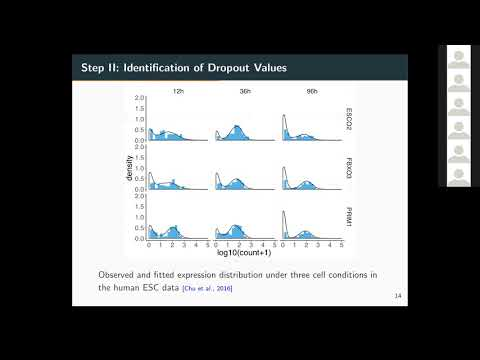

In [2]:
YouTubeVideo('MgwhJWdRjss')

  * <a href=#Reading>1 Reading in the data</a>
  * <a href=#Preprocessing>2 Pre-processing and visualization</a>
    * <a href=#QC>2.1 Quality Control</a>
    * <a href=#Normalization>2.2 Normalization</a>
    * <a href=#HVG>2.3 Highly variable genes</a>
    * <a href=#Visualization>2.4 Visualization</a>
  * <a href=#Downstream>3 Downstream analysis</a>
    * <a href=#Clustering>3.1 Clustering</a>
  * <a href=#Summary>4 Summary</a>

In [3]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb

from rpy2.robjects import pandas2ri

In [4]:
resultfig_path = '../Results/figures/selection/'

sc.settings.n_jobs=12

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 0
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.3 scipy==1.3.1 pandas==0.25.2 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1+4.bed07760 louvain==0.6.1 


In [5]:
# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
%load_ext rpy2.ipython

In [6]:
%%R
# Load all the R libraries we will be using in the notebook
library(scran)

<a id="Reading"></a>
# 1. Reading in the data

Here I load [single-cell RNA-sequencing data](https://support.10xgenomics.com/single-cell-gene-expression/datasets) for the distinct celltypes:

* CD14+ Monocytes
* CD19+ B Cells
* CD4+ Helper T Cells
* CD4+/CD25+ Regulatory T Cells
* CD4+/CD45RO+ Memory T Cells
* CD56+ Natural Killer Cells

For each celltype I downloaded filtered and raw data, then concatenating respective data with celltype labels into one data matrix for downstream analysis.

In [7]:
# Set up data loading

#Data files
file_base = '../Data/'

data_types = ['filtered', 'raw']


celltype_strings = ['b_cells_','cytotoxic_t_','cd4_t_helper_','cd14_monocytes_','naive_cytotoxic_','cd56_nk_','memory_t_','naive_t_','regulatory_t_']
#celltype_strings = ['cd4_t_helper_','regulatory_t_','memory_t_','b_cells_','cd56_nk_',cd14_monocytes_']
celltype_sub = '_gene_bc_matrices'

file_sub = '/filtered_matrices_mex/hg19/'

file_mtx = 'matrix.mtx'
file_bar = 'barcodes.tsv'
file_gen = 'genes.tsv'

In [8]:
# do for both datatypes
#data = []
for data_type in data_types[0:1]:
    data_file = file_base+data_type+"/"+celltype_strings[0]+data_type+celltype_sub+file_sub

    #Load data
    adata = sc.read(data_file+file_mtx, cache=True)
    adata = adata.transpose()
    adata.X = adata.X.toarray()

    barcodes = pd.read_csv(data_file+file_bar, header=None, sep='\t')
    genes = pd.read_csv(data_file+file_gen, header=None, sep='\t')

    #Annotate data
    barcodes.rename(columns={0:'barcode'}, inplace=True)
    barcodes.set_index('barcode', inplace=True)
    adata.obs = barcodes

    adata.obs['celltype'] = [celltype_strings[0]]*adata.n_obs

    genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
    genes.set_index('gene_symbol', inplace=True)
    adata.var = genes
    
    print(adata)
    # Loop to load rest of data sets
    for celltype in celltype_strings[1:]:
        print(celltype)
        data_file = file_base+data_type+"/"+celltype+data_type+celltype_sub+file_sub

        #Load data
        adata_tmp = sc.read(data_file+file_mtx, cache=True)
        adata_tmp = adata_tmp.transpose()
        adata_tmp.X = adata_tmp.X.toarray()

        barcodes_tmp = pd.read_csv(data_file+file_bar, header=None, sep='\t')
        genes_tmp = pd.read_csv(data_file+file_gen, header=None, sep='\t')

        #Annotate data
        barcodes_tmp.rename(columns={0:'barcode'}, inplace=True)
        barcodes_tmp.set_index('barcode', inplace=True)
        adata_tmp.obs = barcodes_tmp
        adata_tmp.obs['celltype'] = [celltype]*adata_tmp.n_obs

        genes_tmp.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
        genes_tmp.set_index('gene_symbol', inplace=True)
        adata_tmp.var = genes_tmp
        adata_tmp.var_names_make_unique()
        
        print(adata_tmp)
        # Concatenate to main adata object
        adata = adata.concatenate(adata_tmp, batch_key='sample_id')
        adata.obs_names = [c.split("-")[0] for c in adata.obs_names]
        adata.obs_names_make_unique(join='_')
#    data.append(adata)

# monocytes in raw data: MemoryError: Unable to allocate array with shape (737280, 32738) and data type float32

AnnData object with n_obs × n_vars = 10085 × 32738 
    obs: 'celltype'
    var: 'gene_id'
cytotoxic_t_
AnnData object with n_obs × n_vars = 10209 × 32738 
    obs: 'celltype'
    var: 'gene_id'


Making variable names unique for controlled concatenation.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


cd4_t_helper_
AnnData object with n_obs × n_vars = 11213 × 32738 
    obs: 'celltype'
    var: 'gene_id'


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


cd14_monocytes_
AnnData object with n_obs × n_vars = 2612 × 32738 
    obs: 'celltype'
    var: 'gene_id'


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Or pass `index_unique!=None` to `.concatenate`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


naive_cytotoxic_
AnnData object with n_obs × n_vars = 11953 × 32738 
    obs: 'celltype'
    var: 'gene_id'


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Or pass `index_unique!=None` to `.concatenate`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


cd56_nk_
AnnData object with n_obs × n_vars = 8385 × 32738 
    obs: 'celltype'
    var: 'gene_id'


MemoryError: Unable to allocate array with shape (54457, 32738) and data type float32

In [9]:
#Write to file
adata.write(file_base + 'filtered.h5ad')

... storing 'celltype' as categorical


<a id="Preprocessing"></a>
# 2 Pre-processing and visualization
<a id="QC"></a>
## 2.1 Quality control

Data quality control can be split into cell QC and gene QC. Typical quality measures for assessing the quality of a cell include the number of molecule counts, the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell.

In [8]:
adata = sc.read(file_base + 'filtered.h5ad', cache=True)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [9]:
# Checking the total size of the data set
print(adata.shape)
# Annotate the data sets
print(adata.obs['celltype'].value_counts())

(52782, 32738)
cd4_t_helper_      11213
regulatory_t_      10263
memory_t_          10224
b_cells_           10085
cd56_nk_            8385
cd14_monocytes_     2612
Name: celltype, dtype: int64


In [10]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']

In [11]:
adata.obs

,celltype,sample_id,n_counts,log_counts,n_genes,mt_frac
index,,,,,,
AAACATACAATGCC,b_cells_,0,2691.0,7.897668,951,0.017466
AAACATACACGCAT,b_cells_,0,2249.0,7.718241,714,0.026234
AAACATACGAATAG,b_cells_,0,1816.0,7.504392,588,0.030286
AAACATACGGTGTT,b_cells_,0,1088.0,6.992096,430,0.024816
AAACATACGTGTCA,b_cells_,0,1752.0,7.468513,637,0.017123
...,...,...,...,...,...,...
TTTGCATGAGAATG,regulatory_t_,1,997.0,6.904751,461,0.027081
TTTGCATGCCTCGT,regulatory_t_,1,941.0,6.846943,446,0.005313
TTTGCATGTAACCG,regulatory_t_,1,1406.0,7.248504,583,0.011380


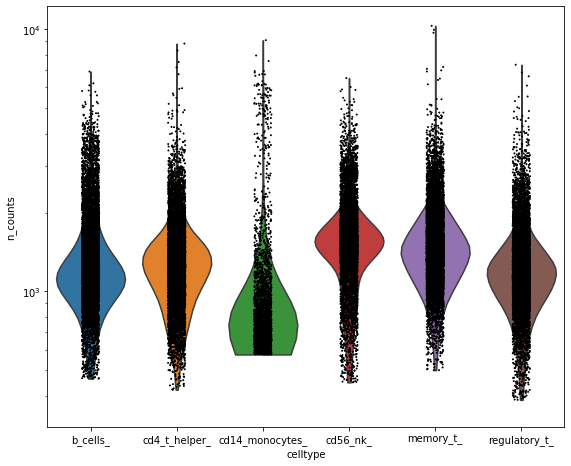

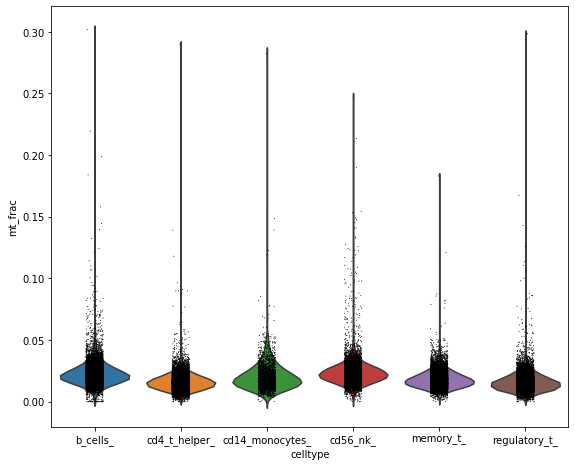

In [23]:
# Quality control - plot QC metrics
#Sample quality plots
t1 = sc.pl.violin(adata, 'n_counts', groupby='celltype', size=2, log=True, cut=0)
t2 = sc.pl.violin(adata, 'mt_frac', groupby='celltype')

The plots show that the cells for every celltype have an overall good quality and the distributions look similar.
The fraction of mitochondrial reads (MT frac) for most cells are far below 20-25%, which are the typical filtering thresholds.

C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\scanpy\plotting\_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\anndata\core\anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\scanpy\plotting\_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\anndata\core\anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarn

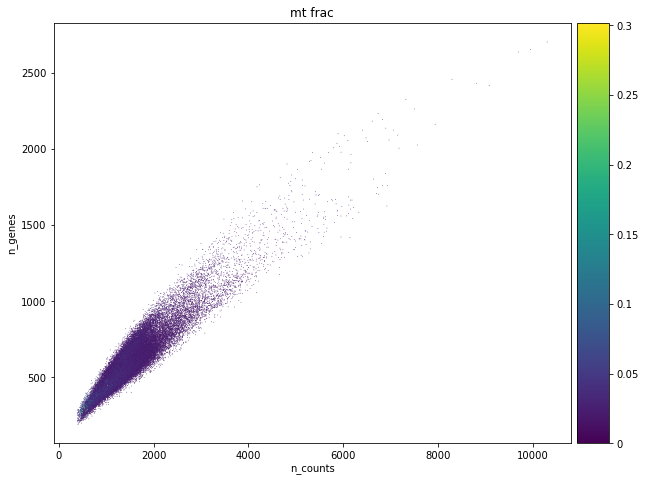

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\scanpy\plotting\_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\anndata\core\anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\scanpy\plotting\_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages

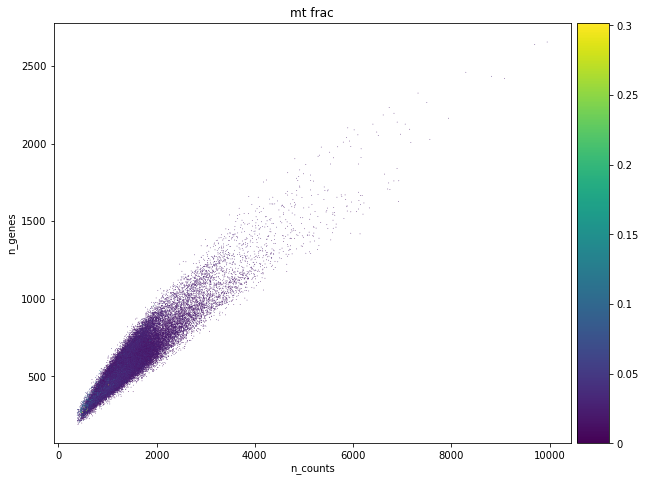

In [24]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac')
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac')

By looking at plots of the number of genes versus the number of counts with MT fraction information, you can assess whether there cells with unexpected summary statistics. It is important here to look at these statistics altogether.

For example, cells with many counts, but few genes could be seen as "dying" outliers if they also have high MT fraction.

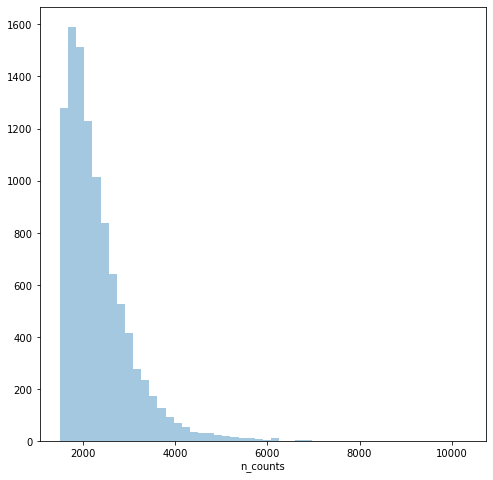

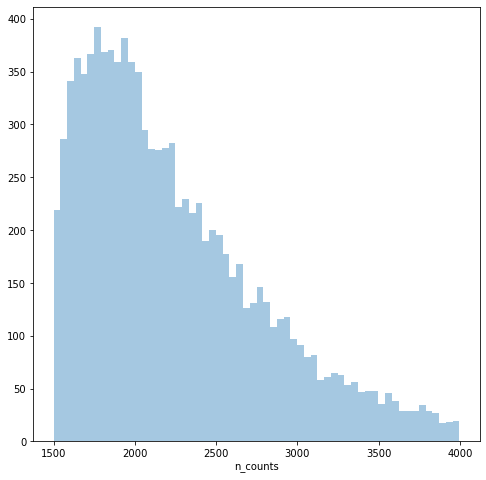

In [52]:
#Thresholding decision: counts
p3 = sb.distplot(adata.obs['n_counts'], kde=False)
plt.show()

p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<4000], kde=False, bins=60)
plt.show()

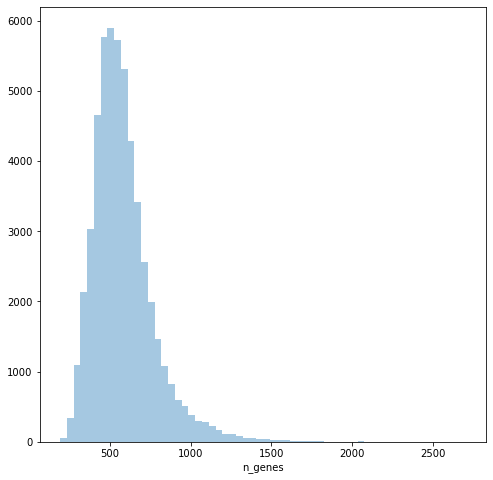

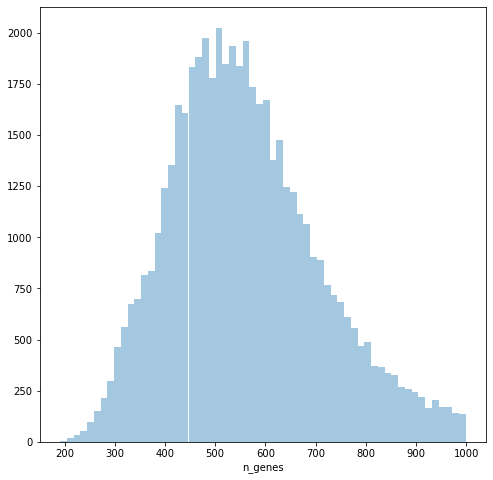

In [26]:
#Thresholding decision: genes
p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde=False, bins=60)
plt.show()

By looking at histograms you can detect outliers as well, for example peaks at high count numbers might give a hint about douplet cells.

In general it is a good idea to be permissive in the early filtering steps, and then come back to filter out more stringently when a clear picture is available of what would be filtered out. This is available after visualization/clustering.

In [27]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 1500)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 40000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 700)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 52782
filtered out 33180 cells that have less than 1500 counts


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Number of cells after min count filter: 19602


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Number of cells after max count filter: 19602
Number of cells after MT filter: 19601
filtered out 9275 cells that have less than 700 genes expressed


Trying to set attribute `.obs` of view, making a copy.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Number of cells after gene filter: 10326


In [28]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 32738
filtered out 20782 genes that are detected in less than 20 cells
Number of genes after cell filter: 11956


The filtering is performed based on common thresholds. Genes are also filtered if they are not detected in at least 20 cells. This reduces the dimensions of the matrix by removing 0 count genes and genes which are not sufficiently informative of the dataset. 

<a id="Normalization"></a>
## 2.2 Normalization
Up to this point the data is only available as a count matrix. Counts are representative of molecules that were captured in the scRNA-seq experiment. As not all mRNA molecules in a cell are captured, there is a variability in the total number of counts detected between cells that results from both the number of molecules that were in the cells, and the sampling. As we cannot assume that all cells contain an equal number of molecules (cell sizes can differ substantially), we have to estimate the number of molecules that were initially in the cells. In fact, we don't estimate the exact number of molecules, but instead estimate cell-specific factors that should be proportional to the true number of molecules. These are called size factors. Normalized expression values are calculated by dividing the measured counts by the size factor for the cell.

In [30]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 15
    finished (0:00:02.87)
computing neighbors
    using 'X_pca' with n_pcs = 15


C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\numba\typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\Anaconda3\envs\sc-tutorial\lib\site-packages\umap\rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\numba\typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\Anaconda3\envs\sc-tutoria

    finished (0:00:08.57) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:02.49) --> found 10 clusters and added
    'groups', the cluster labels (adata.obs, categorical)


In [31]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [32]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [33]:
#Delete adata_pp
del adata_pp

C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\scanpy\plotting\_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\anndata\core\anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\scanpy\plotting\_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\anndata\core\anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarn

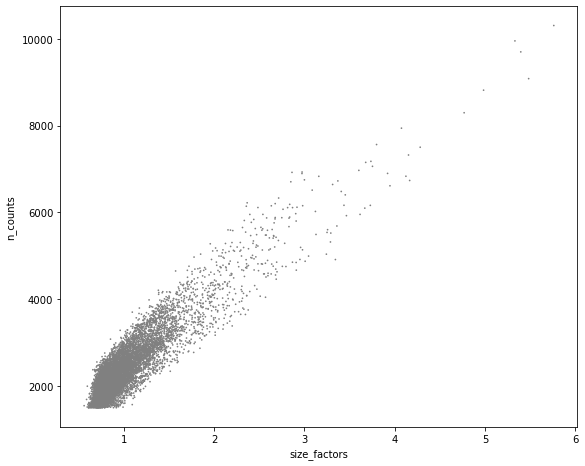

C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\scanpy\plotting\_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\anndata\core\anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\scanpy\plotting\_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\anndata\core\anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarn

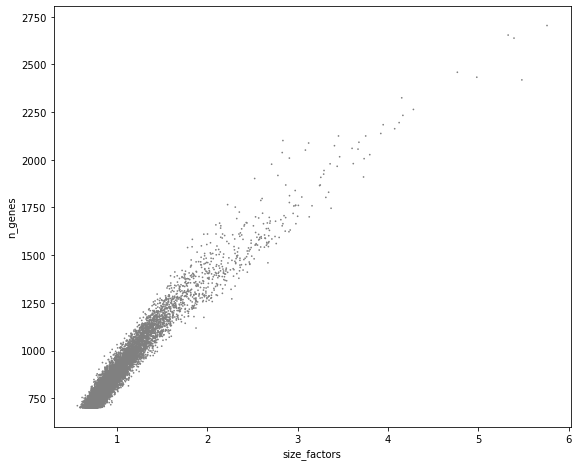

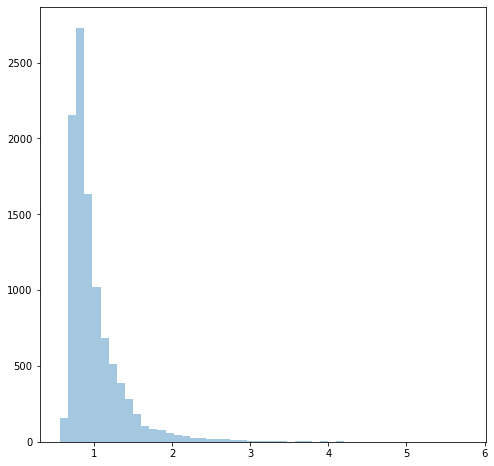

In [34]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

Plotting the size factors shows they are non-negative and related to the number of counts and genes per cell as expected.

In [35]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [36]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [37]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

The count data has been normalized and log-transformed with an offset of 1. The latter is performed to normalize the data distributions. The offset of 1 ensures that zero counts map to zeros.

<a id="HVG"></a>
## 2.3 Highly Variable Genes
Highly variable genes (HVGs) are extracted to further reduce the dimensionality of the dataset and include only the most informative genes. Genes that vary substantially across the dataset are informative of the underlying biological variation in the data. HVGs are used for clustering, and other downstream analyses.

In [38]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 3999


Highly variable gene information is stored automatically in the adata.var['highly_variable'] field. The dataset now contains:
- a 'counts' layer with count data
- log-normalized data in adata.raw
- highly variable gene annotations in adata.var['highly_variable']

The HVG labels can be used to subselect genes for clustering and other downstream analysis.

<a id="Visualization"></a>
## 2.4 Visualization
Visualizing scRNA-seq data is the process of projecting a high-dimensional matrix of cells and genes into a few coordinates such that every cell is meaningfully represented in a two-dimensional graph. However, the visualization of scRNA-seq data is an active area of research and each method defines 'meaningful' in its own way. Thus, it is a good idea to look at several visualizations and decide which visualization best represents the aspect of the data that is being investigated. 

In [42]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.tsne(adata, n_jobs=12) #Note n_jobs works for MulticoreTSNE, but not regular implementation)
sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:04.32)
computing neighbors
    using 'X_pca' with n_pcs = 50


C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\numba\typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\Anaconda3\envs\sc-tutorial\lib\site-packages\umap\nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished (0:00:03.31) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished (0:01:54.05) --> added
    'X_tsne', tSNE coordinates (adata.obsm)
computing UMAP
    using 'X_pca' with n_pcs = 50
    finished (0:00:07.93) --> added
    'X_umap', UMAP coordinates (adata.obsm)
computing Diffusion Maps using n_comps=15(=n_dcs)
    eigenvalues of transition matrix
    [1.         0.99991107 0.9997761  0.99883085 0.9881266  0.9806205
     0.97373426 0.9681225  0.9606778  0.95777845 0.9482823  0.94609267
     0.9410195  0.92781836 0.91313857]
    finished (0:00:00.20) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns)
drawing single-cell graph using layout "fa"
    finished (0:08:05.94) --> added
    'X_draw_graph_fr', g

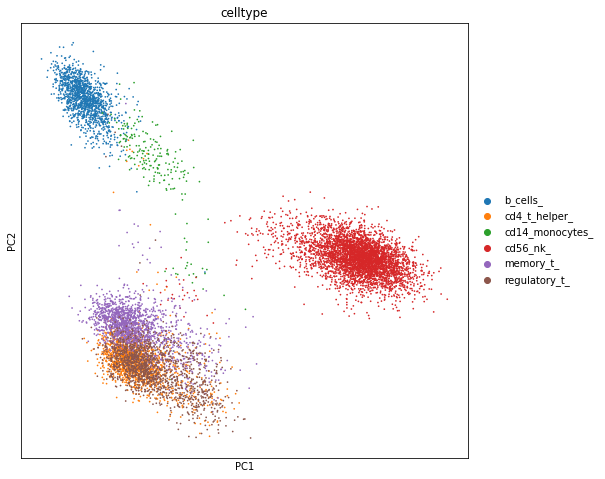

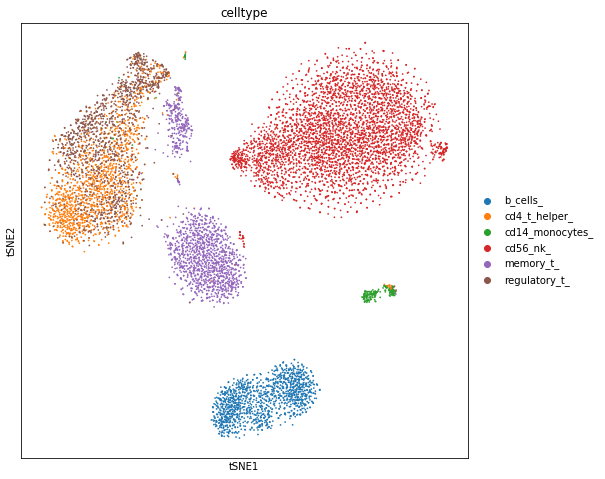

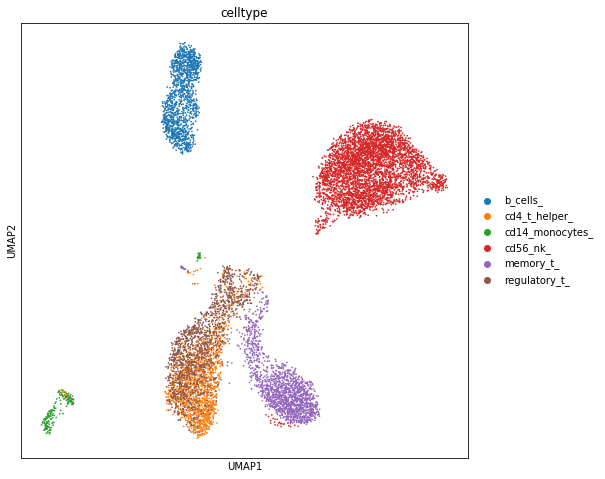

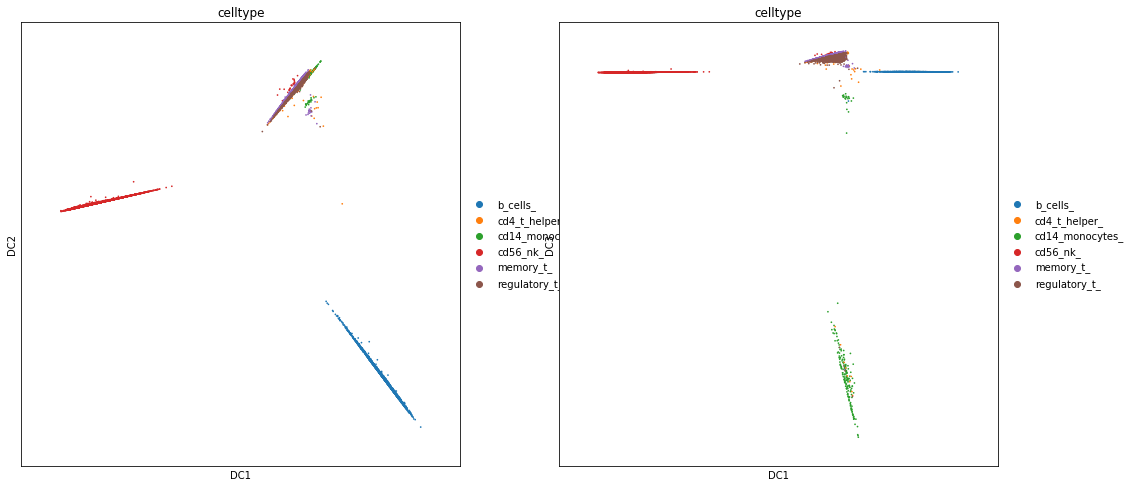

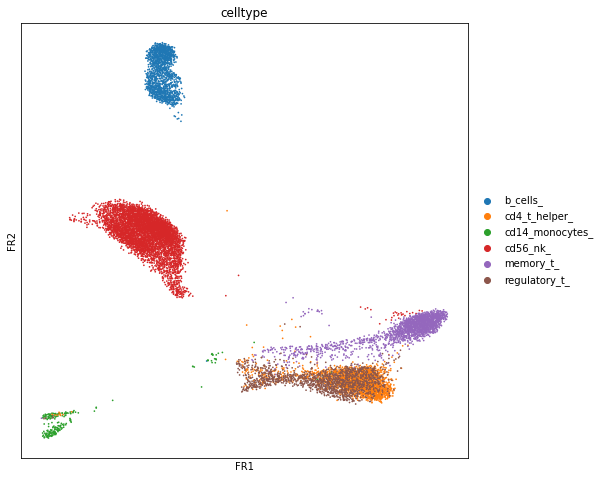

In [44]:
sc.pl.pca_scatter(adata, color='celltype')
sc.pl.tsne(adata, color='celltype')
sc.pl.umap(adata, color='celltype')

<a id="Downstream"></a>
# 3 Downstream analysis
## 3.1 Clustering
Clustering is a central component of the scRNA-seq analysis pipeline. To understand the data, we must identify cell types and states present. The first step of doing so is clustering. Performing Modularity optimization by Louvain community detection on the k-nearest-neighbour graph of cells has become an established practice in scRNA-seq analysis.

Investigating several resolutions allows to select a clustering that appears to capture the main clusters in the visualization and can provide a good baseline for further subclustering of the data to identify more specific substructure.

Clustering is performed on the highly variable gene data, dimensionality reduced by PCA, and embedded into a KNN graph.

In [46]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, key_added='louvain_r1')
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_r0.5')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01.75) --> found 10 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01.23) --> found 7 clusters and added
    'louvain_r0.5', the cluster labels (adata.obs, categorical)


In [47]:
adata.obs['louvain_r0.5'].value_counts()

0    4051
1    2432
2    1596
3    1369
4     548
5     194
6     136
Name: louvain_r0.5, dtype: int64

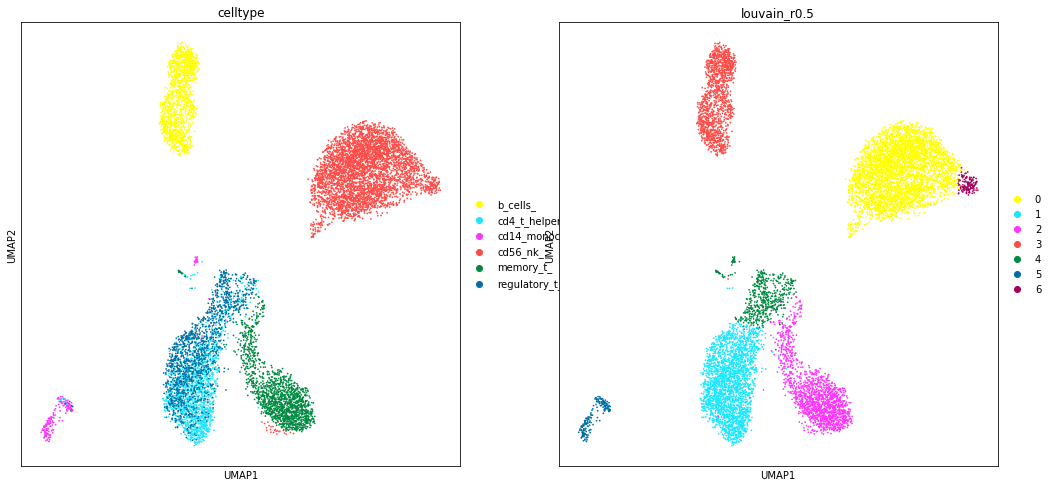

In [53]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color=['celltype', 'louvain_r0.5'], palette=sc.pl.palettes.default_64)

<a id="Summary"></a>
# 4 Summary

[<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41467-018-03405-7/MediaObjects/41467_2018_3405_Fig6_HTML.jpg?as=webp">](comparison)
The size of single samples for raw data was too large to analyse these vai this pipeline and the scImpute method is only available via R-packages, so this project just shows an exemplary workflow of scRNA-seq data analysis with preprocessing of data and visualization as well as an clustering approach.